In [241]:
#from EKFsimplev2 import ExtendedKalmanFilter
import control
import matplotlib as plt
import time


Connection du thymio

In [242]:
!pip install --upgrade tdmclient

Création du node de controle

In [244]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 19b33216-bf6c-43ca-99c3-fd3e41d0251a

Initialisation des librairies utilisées

In [245]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm

Initialisation du kalman filter pour le detecteur de vitesse

In [283]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

Essai de kalman en direct

In [393]:
import numpy as np
import numpy.matlib
from math import pi, sqrt


class ExtendedKalmanFilter:
    def __init__(self):
        '''
        Each object being tracked will result in the creation of a new ExtendedKalmanFilter instance.
        TODO: consider making these just class methods; that way we don't have many instances and instead
        each tracker will just call to these methods with the matrices to update.
        '''

        #do this once do we don't keep redoing in update step
        self.__xI = np.matlib.identity(5)

        self.__x = None
        self.__F = None
        self.__Q = None

        self.__P = np.matrix([[1,0,0,0,0],
                              [0,1,0,0,0],
                              [0,0,1,0,0],
                              [0,0,0,1,0],
                              [0,0,0,0,1]])

        self.__HT = np.matrix([[0,0,0,1,0],
                              [0,0,0,0,1]])  #matrice de mesure pour translation pure
    
        self.__HR = np.matrix([[0,0,0,1,0],
                              [0,0,0,0,1]])  #matrice de mesure pour rotation pure

        #à calibrer
        self.__RT = np.matrix([[7,0],
                               [0,7]])

        self.__RR = np.matrix([[7,0],
                               [0,7]])

        #we can adjust these to get better accuracy
        self.__noise_ax = 1
        self.__noise_ay = 1

    @property
    def current_estimate(self):
        return (self.__x, self.__P)
    
    def current_estimate_state(self):
     #   print("current_estimate_state")
        return (self.__x)


    def init_state_vector(self, x,y,alpha, v, omega):
        self.__x = np.matrix([[x,y,alpha,v, omega]]).T

    def recompute_F_and_Q(self, dt):
        '''
        updates the motion model and process covar based on delta time from last measurement.
        '''

        #set F
       # print("je suis la")
       # print()
        etat = self.current_estimate
       # print(etat[0][2])
        

        alpha = etat[0][2] #je veux tirer alpha de mon vecteur d'etats avant prediction
       # print(alpha)
        vitesse = etat[0][3].item(0) #tirer la vitesse
       # print(vitesse)
        print()
       # print(np.sin(1))
       # print(np.sin(alpha).item(0))
       # print(np.cos(alpha).item(0))

        alpha_sin = np.sin(alpha).item(0)
        alpha_cos = np.cos(alpha).item(0)
        print("_____________________norme de la vitesse et angle ___________")
        print(vitesse)
        print(alpha)
        print("____________________________________________________")
        e13 = -alpha_sin*dt*vitesse 
        e14 = alpha_cos*dt
        e23 = alpha_cos*dt*vitesse
        e24 = alpha_sin*dt
        e35 = dt
        
        print("nouveau y")
        print(e23)
        print(e24)
        print(e23*self.__x[2] + e24*self.__x[3])


        self.__F = np.matrix([[1, 0, e13, e14,   0],
                              [0, 1, e23, e24,   0],
                              [0, 0,   1,   0, e35],
                              [0, 0,   0,   1,   0],
                              [0, 0,   0,   0,   1]])
        #set Q
        e11 = 0.1
        e22 = 0.1
        e33 = 0.1
        e44 = 1
        e55 = 1

        self.__Q = np.matrix([[e11, 0, 0, 0, 0],
                              [0, e22, 0, 0, 0],
                              [0, 0, e33, 0, 0],
                              [0, 0, 0, e44, 0],
                              [0, 0, 0, 0, e55]])

    def predict(self):
        '''
        This is a projection step. we predict into the future.
        '''
        self.__x = self.__F * self.__x
        self.__P = (self.__F * self.__P * self.__F.T) + self.__Q

    def updateTransSpeed(self,speedTrans):
        '''
        This is the projection correction; after we predict we use the sensor data
        and use the kalman gain to figure out how much of the correction we need.
        '''
        print("dans vitesse de translation")
        #this is the error of our prediction to the sensor readings
        y = [[speedTrans],[0]] - self.__HT*self.__x
     #   print("y")
     #   print(y)
       # print("Ht*x")
       # print(self.__HT*self.__x)
       # print("[ ]")
       # print([speedTrans,0])
        #pre compute for the kalman gain K
        PHLt = self.__P * self.__HT.T
        S = self.__HT * PHLt + self.__RT
        K = PHLt*S.I
       # print("K")
        #print(K)

        #now we update our prediction using the error and kalman gain.
        self.__x += K*y
        self.__P = (self.__xI - K*self.__HT) * self.__P

    def updateRotaSpeed(self,speedRota):
        '''
        This is the projection correction; after we predict we use the sensor data
        and use the kalman gain to figure out how much of the correction we need.
        This is a special case as we will need a Jocabian matrix to have a linear
        approximation of the transformation function h(x)
        '''
        print("dans vitesse de rotation")

        #this is the error of our prediction to the sensor readings
        y = [[0],[speedRota]] - self.__HR*self.__x

        #pre compute for the kalman gain K
        PHLt = self.__P * self.__HR.T
        S = self.__HR * PHLt + self.__RR
        K = PHLt*S.I

        #now we update our prediction using the error and kalman gain.
        self.__x += K*y
        self.__P = (self.__xI - K*self.__HR) * self.__P

In [ ]:
import numpy as np
import numpy.matlib
from math import pi, sqrt


class ExtendedKalmanFilterComplete:
    def __init__(self):
        '''
        Each object being tracked will result in the creation of a new ExtendedKalmanFilter instance.
        TODO: consider making these just class methods; that way we don't have many instances and instead
        each tracker will just call to these methods with the matrices to update.
        '''

        #do this once do we don't keep redoing in update step
        self.__xI = np.matlib.identity(5)

        self.__x = None
        self.__F = None
        self.__Q = None

        self.__P = np.matrix([[1,0,0,0,0],
                              [0,1,0,0,0],
                              [0,0,1,0,0],
                              [0,0,0,1,0],
                              [0,0,0,0,1]])

        self.__H = np.matrix([[1,0,0,0,0],
                              [0,1,0,0,0],
                              [0,0,1,0,0],
                              [0,0,0,1,0],
                              [0,0,0,0,1]])  #matrice de mesure pour translation pure
    

        #à calibrer
        self.__R = np.matrix([[5,0,0,0,0],
                              [0,5,0,0,0],
                              [0,0,1,0,0],
                              [0,0,0,7,0],
                              [0,0,0,0,2]])

        #we can adjust these to get better accuracy
        self.__noise_ax = 1
        self.__noise_ay = 1

    @property
    def current_estimate(self):
        return (self.__x, self.__P)
    
    def current_estimate_state(self):
     #   print("current_estimate_state")
        return (self.__x)


    def init_state_vector(self, x,y,alpha, v, omega):
        self.__x = np.matrix([[x,y,alpha,v, omega]]).T

    def recompute_F_and_Q(self, dt):
        '''
        updates the motion model and process covar based on delta time from last measurement.
        '''

        #set F
       # print("je suis la")
        etat = self.current_estimate        

        alpha = etat[0][2] #je veux tirer alpha de mon vecteur d'etats avant prediction
        vitesse = etat[0][3].item(0) #tirer la vitesse

        alpha_sin = np.sin(alpha).item(0)
        alpha_cos = np.cos(alpha).item(0)
        print("_____________________norme de la vitesse et angle ___________")
        print(vitesse)
        print(alpha)
        print("____________________________________________________")
        e13 = -alpha_sin*dt*vitesse 
        e14 = alpha_cos*dt
        e23 = alpha_cos*dt*vitesse
        e24 = alpha_sin*dt
        e35 = dt
        
        print("nouveau y")
        print(e23)
        print(e24)
        print(e23*self.__x[2] + e24*self.__x[3])


        self.__F = np.matrix([[1, 0, e13, e14,   0],
                              [0, 1, e23, e24,   0],
                              [0, 0,   1,   0, e35],
                              [0, 0,   0,   1,   0],
                              [0, 0,   0,   0,   1]])
        #set Q
        e11 = 0.1
        e22 = 0.1
        e33 = 0.1
        e44 = 1
        e55 = 1

        self.__Q = np.matrix([[e11, 0, 0, 0, 0],
                              [0, e22, 0, 0, 0],
                              [0, 0, e33, 0, 0],
                              [0, 0, 0, e44, 0],
                              [0, 0, 0, 0, e55]])

    def predict(self):
        '''
        This is a projection step. we predict into the future.
        '''
        self.__x = self.__F * self.__x
        self.__P = (self.__F * self.__P * self.__F.T) + self.__Q

    def update(self,sensor_package):
        '''
        This is the projection correction; after we predict we use the sensor data
        and use the kalman gain to figure out how much of the correction we need.
        '''
        Rthymio = 0.045
        posx = sensor_package[0]
        posy = sensor_package[1]
        angle_sensor = sensor_package[2]

        if(rotation):
            '''
            mettre vitesse de translation nulle
            '''
            vit_trans = 0
            # pour avoir meme angle: si vitesse roue droite > 0 : sens positif. donc sensor_package[3] : roue gauche
            vit_rot = sensor_package[4]/Rthymio

        else:
            '''
            mettre vitesse de rotation nulle
            '''
            vit_trans = (sensor_package_package[3]+sensor_package[4])/2
            vit_rot = 0
        
        #this is the error of our prediction to the sensor readings
        y = [[posx],[posy],[angle_sensor],[vit_trans],[vit_rot]] - self.__H*self.__x
        
        #pre compute for the kalman gain K
        PHLt = self.__P * self.__H.T
        S = self.__H * PHLt + self.__R
        K = PHLt*S.I

        #now we update our prediction using the error and kalman gain.
        self.__x += K*y
        self.__P = (self.__xI - K*self.__H) * self.__P

STRAIGHT
0.217207670211792

_____________________norme de la vitesse et angle ___________
0
[[0]]
____________________________________________________
nouveau y
0.0
0.0
[[0.]]
0.15288281440734863

_____________________norme de la vitesse et angle ___________
0.0
[[0.]]
____________________________________________________
nouveau y
0.0
0.0
[[0.]]
0.1210780143737793

_____________________norme de la vitesse et angle ___________
0.0
[[0.]]
____________________________________________________
nouveau y
0.0
0.0
[[0.]]
0.1659104824066162

_____________________norme de la vitesse et angle ___________
0.0
[[0.]]
____________________________________________________
nouveau y
0.0
0.13943719863891602

_____________________norme de la vitesse et angle ___________
0.0
[[0.]]
____________________________________________________
0.0nouveau y
[[0.]]

0.0
0.0
0.07859611511230469[[0.]]


_____________________norme de la vitesse et angle ___________
0.0
[[0.]]
____________________________________________

0.09596705436706543

_____________________norme de la vitesse et angle ___________
19.87828145166561
[[0.]]
____________________________________________________
nouveau y
1.907660116795822
0.0
[[0.]]
dans vitesse de translation
0.09229922294616699

_____________________norme de la vitesse et angle ___________
19.87828145166561
[[0.]]
____________________________________________________
nouveau y
1.8347499314939402
0.0
[[0.]]
dans vitesse de translation
0.0968780517578125

_____________________norme de la vitesse et angle ___________
19.900552532091023
[[0.]]
____________________________________________________
nouveau y
1.9279267582129807
0.0
[[0.]]
dans vitesse de translation
0.10283851623535156

_____________________norme de la vitesse et angle ___________
20.03452046914985
[[0.]]
____________________________________________________
nouveau y
2.06032035853415
0.0
[[0.]]
dans vitesse de translation
0.10949540138244629

_____________________norme de la vitesse et angle ___________
20.0

0.11739778518676758

_____________________norme de la vitesse et angle ___________
19.81274310970722
[[0.70592683]]
____________________________________________________
nouveau y
1.7700894850385656
0.07616057296703427
[[2.75850353]]
dans vitesse de translation
0.10623049736022949

_____________________norme de la vitesse et angle ___________
19.63014078093565
[[0.70644263]]
____________________________________________________
nouveau y
1.586252353298748
0.0689576020719259
[[2.47424372]]
dans vitesse de translation
0.1056671142578125

_____________________norme de la vitesse et angle ___________
19.49648771102253
[[0.70671729]]
____________________________________________________
nouveau y
1.5667296242056008
0.06861396680661941
[[2.44496628]]
dans vitesse de translation
0.09586095809936523

_____________________norme de la vitesse et angle ___________
19.988379811023936
[[0.70690168]]
____________________________________________________
nouveau y
1.456963931851318
0.06225987063204152
[[

dans vitesse de translation
0.10963630676269531

_____________________norme de la vitesse et angle ___________
7.981746245706484
[[1.51018195]]
____________________________________________________
nouveau y
0.05301050654447859
0.10943496092613776
[[0.9535376]]
0.102630615234375

_____________________norme de la vitesse et angle ___________
7.981746245706484
[[1.52004059]]
____________________________________________________
nouveau y
0.04155980731811851
0.10249844793350893
[[0.8812892]]
dans vitesse de translation
dans vitesse de translation
0.12029099464416504

_____________________norme de la vitesse et angle ___________
13.675004064508848
[[1.51728832]]
____________________________________________________
nouveau y
0.08797759380149238
0.12011883275692246
[[1.7761129]]
dans vitesse de translation
0.09299230575561523

_____________________norme de la vitesse et angle ___________
15.627844011692945
[[1.51933711]]
____________________________________________________
nouveau y
0.07475109

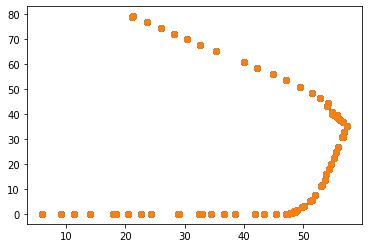

In [394]:
speed_conv_factor = 0.38;
marche_avant=True;
Ts = 0.1
#KF=ExtendedKalmanFilterComplete()
KF=ExtendedKalmanFilter()
KF.init_state_vector(0,0,0,0,0)
tab_etats = []
tab_etats_predits = []
tab_pos_misajour = []
tab_vit_misajour = []
avg_speed = []
speed_command = []
rota_command = []
rotation = False
Rthymio = 0.045 #A MODIFER
ts = time.time()  #temps initial pour premiere mesure
marq = time.time()

compteur = 0

get_data = []

#permet de passer a vitesse de commande à vitesse mm/s. 
marche_avant=True;
ax = plt.subplot(1, 1, 1)


if marche_avant:
    await node.wait_for_variables() # wait for Thymio variables values
    rt = RepeatedTimer(Ts, KalmanStep(rotation,[])) # it auto-starts, no need of rt.start()
    try:
 # time.sleep would not work here, use asynchronous client.sleep method instead
        print('STRAIGHT')
        control.set_motors(50,50,node)
        TPS = time.time() 

        await client.sleep(2)
        print('ROTATION')
        rotation=True
        control.set_motors(50,-50,node)
        await client.sleep(1.7)
        
        print('STRAIGHT')
        rotation=False
        control.set_motors(50,50,node)
        await client.sleep(2)
        
        print('ROTATION')
        rotation=True
        control.set_motors(50,-50,node)
        await client.sleep(2)
        
        print('STRAIGHT')
        rotation=False
        control.set_motors(50,50,node)
        await client.sleep(2)
        
        
    finally:
        rt.stop() # better in a try/finally block to make sure the program ends!
        control.set_motors(0,0,node)


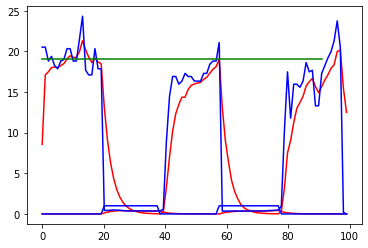

In [379]:
positions = np.squeeze(np.asarray(tab_pos_misajour))
#print(positions)
vitesses = np.squeeze(np.asarray(tab_vit_misajour))
#print(vitesses)
speed_conv_factor = 0.38;
vitesses_moy = np.squeeze(np.asarray(avg_speed))

#print(vitesses_moy)

command_pos = []
vit_command = []
pos_com_increments = []
for i in range(91):
    vit_command.append(50*speed_conv_factor)

a = np.squeeze(np.asarray(vit_command))
#print(vit_command)

pos_com_increments = a[20:]*(speed_conv_factor*Ts)
command_pos= np.cumsum(pos_com_increments)
#print(command_pos)

# increments de commande
#print(pos_com_increments)
# increments liés au capteur de vitesse
#print(pos_increments)

print()


#print(type(vitesses_moy))
pos_increments = vitesses_moy[20:]*(Ts)
odom_pos= np.cumsum(pos_increments)

#x = np.linspace(0, len(positions), len(positions))
#plt.plot(x,positions, "r", label="Kalman position")

#x = np.linspace(0, len(odom_pos), len(odom_pos))
#plt.plot(x, odom_pos, "b",label="Brute speed sensor")

#x = np.linspace(0, len(command_pos), len(command_pos))
#plt.plot(x, command_pos, "g", label="position ideale")

#plt.show()

#construction de la comparaison des vitesses

#vitesse dans etats
x = np.linspace(0, len(vitesses), len(vitesses))
plt.plot(x,vitesses, "r", label="Kalman position")

#vitesses captés bruts des capteurs
x = np.linspace(0, len(vitesses_moy), len(vitesses_moy))
plt.plot(x, vitesses_moy, "b", label="Brute speed sensor")

#print(vit_command)
x = np.linspace(0, len(vit_command), len(vit_command))
plt.plot(x, vit_command,"g", label="position ideale")

plt.show()

In [380]:
def KalmanStep(rotation, sensor_package):
    global tab_etat, tab_pos_misajour, tab_vit_misajour, avg_speed, speed_conv_factor, Ts, rotation, Rthymio, ax, speed_command, rota_command, ts
    
    #1st we calculate how much time has passed since our last measurement_packet in seconds, a ameliorer Ts n'est pas forcement 
    #constant
    dt = time.time() -ts
    print(dt)
    ts = time.time()
    #2nd set new F and Q using new dt
    KF.recompute_F_and_Q(dt)

    #3rd make a prediction
    KF.predict()

    #4th update prediction

    speed =  control.read_motors_speed(node,client);
  #  print(speed)
    
    #on peut mettre le Rthymio en constante, qui est long entre centre roue et roues
    #CHANGER CE QUIL Y A ENVOYE DANS LES UPDATE!!
    
    if rotation:
        speed = speed_conv_factor*10**(-3)*(speed[0]/Rthymio)
     #   print(speed)
        KF.updateRotaSpeed(speed)
        rota_command.append(sensor_package speed_conv_factor*10**(-3)*(50/Rthymio))
    else:
        speed = speed_conv_factor*(speed[0]+speed[1])/2;
   #     print(speed)
        KF.updateTransSpeed(speed)
        speed_command.append(50*speed_conv_factor)
    
    etat = KF.current_estimate_state()

    XYAlpha = [etat.item(0),etat.item(1),etat.item(2)]
    VOmega = [etat.item(3),etat.item(4)]
   # print(XYAlpha)
   # print(VOmega)
    appendarg = [speed,rotation]
    avg_speed.append(appendarg)
    tab_pos_misajour.append(XYAlpha);
    tab_vit_misajour.append(VOmega);
    
    ax.scatter(xpos,ypos)
        

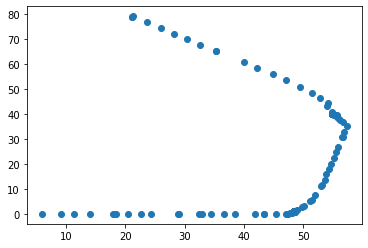

In [390]:
ax = plt.subplot(1, 1, 1)
xpos = [row[0] for row in tab_pos_misajour]
ypos = [row[1] for row in tab_pos_misajour]
#print(ypos)
ax.scatter(xpos,ypos)

99
99
65.18358014337049


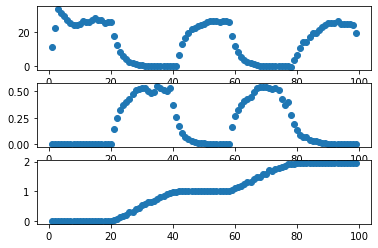

In [371]:
#vitesse straight
ax = plt.subplot(3, 1, 1)
xvit = [row[0] for row in tab_vit_misajour]
yvit = [row[1] for row in tab_vit_misajour]
temps = np.linspace(1,len(xvit),len(xvit))
print(len(temps))
print(len(xvit))
ax.scatter(temps,xvit)
#vitesse angulaire
ax = plt.subplot(3, 1, 2)
ax.scatter(temps,yvit)
ax = plt.subplot(3, 1, 3)
angle = [row[2] for row in tab_pos_misajour]
ax.scatter(temps,angle)
print(angle[60]*180/pi)

In [372]:
print(rota_command)
print(yvit[46:100])


[0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556]
[0.022475016339391318, 0.015405394836442564, 0.010570378686111308, 0.007256340578184448, 0.0049824556053040935, 0.003421493607571435, 0.0023496867227415725, 0.0016136693027259405, 0.0011082149148701485, 0.000693087017732572, 0.000456744956

In [373]:
# using time module
import time
  
# ts stores the time in seconds
ts = time.time()
  
# print the current timestamp
print(ts)

1638898474.7358475


In [377]:
print("lol")
control.set_motors(-50,50,node)
await client.sleep(5)
control.set_motors(0,0,node)

print("stop")

lol
stop
